In [1]:
import sys
sys.path.append('../../..')

## CMST_SegMain

In [2]:
import numpy
import lasp.differential
import lasp.utils
import lasp.filters.linear
import lasp.thresholding

def mumford_shah(
    y: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta: float,
    sigma: float,
    nb_iterations: int,
    tolerance: float,
    error_history: list[float] = None
) -> numpy.ndarray:

    """Mumford Shah
    
    Solve argmin_{x} { (alpha/2) || y - Hx ||^2 + (beta/2) || nabla y ||^2 + || nabla y ||_1
    """

    Dx = lasp.differential.dx
    Dy = lasp.differential.dy
    Dxt = lasp.differential.dxT
    Dyt = lasp.differential.dyT

    # Build kernel
    uker = numpy.zeros_like(y)

    laplacian = lasp.filters.linear.laplacian()
    lap_diag = lasp.utils.fourier_diagonalization(
        kernel = laplacian,
        shape_out = y.shape 
    )
   
    h_diag = lasp.utils.fourier_diagonalization(
        kernel = h,
        shape_out = y.shape
    )

    h2_diag = numpy.abs(h_diag)**2


    uker = alpha * h2_diag + (beta+sigma) * lap_diag

    rhs1fft = alpha * numpy.conj(h_diag) * numpy.fft.fft2(y)

    # Initialization
    u = numpy.copy(y) 
    d_x=numpy.zeros_like(y)
    d_y=numpy.zeros_like(y)
    b_x=numpy.zeros_like(y)
    b_y=numpy.zeros_like(y)

    for _ in range(0, nb_iterations):

        rhs2 = sigma*Dxt(d_x-b_x)+sigma*Dyt(d_y-b_y)
        rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

        u0=numpy.copy(u)
        
        u = numpy.real(numpy.fft.ifft2(rhsfft / uker))    

        err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
        
        if not(error_history is None):
            error_history.append(err)

        if err < tolerance:
            break
        
        d_x, d_y = lasp.thresholding.multidimensional_soft(
            d = numpy.array([ Dx(u)+b_x, Dy(u)+b_y ]),
            epsilon = 1/sigma
        )

        b_x=b_x+Dx(u)-d_x
        b_y=b_y+Dy(u)-d_y

    u_normalized = lasp.utils.normalize(u)

    return u_normalized

In [3]:
import lasp.filters.linear
import lasp.noise
import lasp.io

import pathlib

import numpy

import scipy.signal
import scipy.io

import matplotlib.pyplot

dataset_path = pathlib.Path('dataset')
filenames = list(set(dataset_path.glob('*.npy')) - set(dataset_path.glob('kernel.npy')))
filenames.sort()
imgs = [ lasp.io.read(filename).astype(numpy.double) for filename in filenames ]
kernel = lasp.io.read(dataset_path / 'kernel.npy')

NB_IMAGES = len(filenames)

print(filenames)


[PosixPath('dataset/BaboonBlurred.npy'), PosixPath('dataset/BaboonNoised.npy'), PosixPath('dataset/BaboonOriginal.npy'), PosixPath('dataset/BoatsBlurred.npy'), PosixPath('dataset/BoatsNoised.npy'), PosixPath('dataset/BoatsOriginal.npy'), PosixPath('dataset/CameramanBlurred.npy'), PosixPath('dataset/CameramanNoised.npy'), PosixPath('dataset/CameramanOriginal.npy'), PosixPath('dataset/GoldhillBlurred.npy'), PosixPath('dataset/GoldhillNoised.npy'), PosixPath('dataset/GoldhillOriginal.npy'), PosixPath('dataset/PeppersBlurred.npy'), PosixPath('dataset/PeppersNoised.npy'), PosixPath('dataset/PeppersOriginal.npy')]


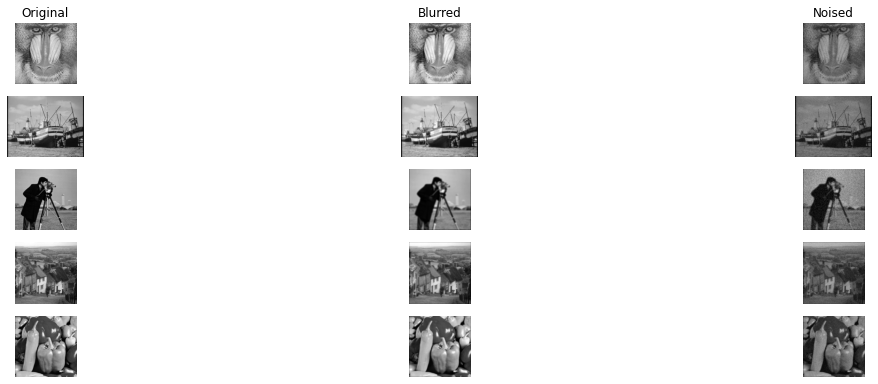

In [4]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))


for i in range(0, NB_IMAGES, 3):

    original = imgs[i+2]
    blurred = imgs[i]
    noised = imgs[i+1]

    

    matplotlib.pyplot.subplot(NB_IMAGES, 3, i+1)
    matplotlib.pyplot.axis('off')
    if(i == 0):
        matplotlib.pyplot.title('Original')
    matplotlib.pyplot.imshow(original, cmap='gray')

    matplotlib.pyplot.subplot(NB_IMAGES, 3, i+2)
    matplotlib.pyplot.axis('off')
    if(i == 0):
        matplotlib.pyplot.title('Blurred')
    matplotlib.pyplot.imshow(blurred, cmap='gray')

    matplotlib.pyplot.subplot(NB_IMAGES, 3, i+3)
    matplotlib.pyplot.axis('off')
    if(i == 0):
        matplotlib.pyplot.title('Noised')
    matplotlib.pyplot.imshow(noised, cmap='gray')

matplotlib.pyplot.show()

In [5]:
import lasp.utils

import numpy
import numpy.linalg

import pandas

all_errors: dict[str, list[float]]= {}
img_results: list[numpy.ndarray] = []

for filename, img in zip(filenames, imgs):
    errors = []
    res = mumford_shah(
        y=img,
        h=kernel,
        alpha=100,
        beta=1,
        sigma=2,
        nb_iterations=300,
        tolerance=10**(-4),
        error_history=errors
    )
    img_results.append(res)
    img_name = filename.stem
    all_errors[img_name] = pandas.Series(errors)


In [6]:
dataframe = pandas.DataFrame(data=all_errors)

In [7]:
dataframe

,BaboonBlurred,BaboonNoised,BaboonOriginal,BoatsBlurred,BoatsNoised,BoatsOriginal,CameramanBlurred,CameramanNoised,CameramanOriginal,GoldhillBlurred,GoldhillNoised,GoldhillOriginal,PeppersBlurred,PeppersNoised,PeppersOriginal
0,0.427896,0.451407,0.450147,0.427684,0.450239,0.437723,0.431911,0.453264,0.452486,0.428588,0.451692,0.437427,0.429862,0.451832,0.438773
1,0.014667,0.040332,0.056298,0.011466,0.038337,0.039716,0.019810,0.041430,0.056981,0.015532,0.039873,0.039605,0.014754,0.038606,0.036447
2,0.006102,0.021832,0.028577,0.004432,0.020974,0.019053,0.008209,0.021877,0.027841,0.006722,0.021783,0.019366,0.006038,0.021046,0.017295
3,0.002968,0.012583,0.016063,0.002115,0.012119,0.010389,0.004099,0.012505,0.015504,0.003432,0.012576,0.010568,0.003010,0.012137,0.009417
4,0.001598,0.007568,0.009483,0.001129,0.007302,0.006007,0.002251,0.007487,0.009093,0.001880,0.007568,0.006100,0.001642,0.007300,0.005446
5,0.000904,0.004646,0.005740,0.000630,0.004489,0.003576,0.001281,0.004585,0.005468,0.001088,0.004646,0.003624,0.000935,0.004480,0.003244
6,0.000527,0.002887,0.003527,0.000364,0.002793,0.002166,0.000748,0.002845,0.003337,0.000641,0.002886,0.002192,0.000547,0.002783,0.001967
7,0.000312,0.001809,0.002188,0.000215,0.001751,0.001327,0.000445,0.001781,0.002057,0.000382,0.001807,0.001341,0.000326,0.001743,0.001206
8,0.000188,0.001140,0.001367,0.000129,0.001104,0.000820,0.000268,0.001121,0.001277,0.000231,0.001138,0.000828,0.000197,0.001098,0.000746
9,0.000114,0.000722,0.000859,0.000078,0.000700,0.000510,0.000163,0.000710,0.000797,0.000141,0.000720,0.000514,0.000120,0.000695,0.000464


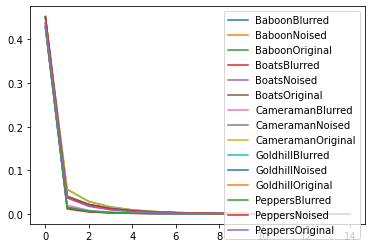

In [8]:
_ = dataframe.plot()

In [9]:
import lasp.io
path_results = pathlib.Path('python_results')
if not(path_results.exists()):
    path_results.mkdir()

for filename, img_res in zip(filenames, img_results):
    lasp.io.save(img_res, path_results / (filename.stem + '.npy'))